# 03 — Market Features

**Phase 2a: Feature Engineering**

## What you'll learn

- Why **natural gas prices** are the #1 external driver of electricity prices
- How **EUR/NOK exchange rate** connects to electricity markets
- What Statnett **production/consumption** data tells us about supply/demand
- How to **resample daily data to hourly** (forward-fill)
- Why NVE **reservoir levels** are critical for a hydro-dominated grid

## The European electricity pricing mechanism

Norwegian electricity prices are set by the **marginal cost** of the most expensive generator needed to meet demand:

```
Cheapest → Most expensive (merit order):
  Wind/Solar (near-zero marginal cost)
  → Hydro (low, depends on reservoir levels)
  → Nuclear (medium, mostly Sweden/Finland)
  → Gas (expensive — sets the price when needed)
  → Coal/Oil (most expensive)
```

Even though Norway is 95% hydro, it's connected to Europe via cables. When European gas prices rise, they pull Norwegian prices up through cable exports.

In [1]:
import sys
from pathlib import Path

# Add project root to path so 'from src...' imports work
PROJECT_ROOT = str(Path.cwd().parent) if Path("../src").exists() else str(Path.cwd())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Commodity Prices — The Gas-Electricity Link

TTF (Title Transfer Facility) is the European natural gas benchmark. When TTF rises, gas-fired power plants in Europe cost more to run, pushing up electricity prices everywhere — including Norway via interconnectors.

In [2]:
from src.data.fetch_commodity import fetch_commodities_daily_filled

commodities = fetch_commodities_daily_filled("2020-01-01", "2026-02-22", cache=True)

print(f"Shape: {commodities.shape}")
print(f"Columns: {list(commodities.columns)}")
print(f"\nBasic stats (close prices):")
close_cols = [c for c in commodities.columns if "close" in c]
print(commodities[close_cols].describe().round(2))

Shape: (2245, 16)
Columns: ['TTF-GAS_open', 'TTF-GAS_high', 'TTF-GAS_low', 'TTF-GAS_close', 'BRENTOIL-SPOT_open', 'BRENTOIL-SPOT_high', 'BRENTOIL-SPOT_low', 'BRENTOIL-SPOT_close', 'NG-FUT_open', 'NG-FUT_high', 'NG-FUT_low', 'NG-FUT_close', 'COAL_open', 'COAL_high', 'COAL_low', 'COAL_close']

Basic stats (close prices):
       TTF-GAS_close  BRENTOIL-SPOT_close  NG-FUT_close  COAL_close
count        2245.00              2245.00       2245.00     2245.00
mean           49.79                73.71          3.52      132.21
std            45.86                18.59          1.69       82.35
min             3.51                19.33          1.48       38.60
25%            26.20                64.89          2.43       93.00
50%            35.01                74.88          2.96      110.30
75%            51.01                84.38          4.03      138.00
max           339.20               127.98          9.68      438.35


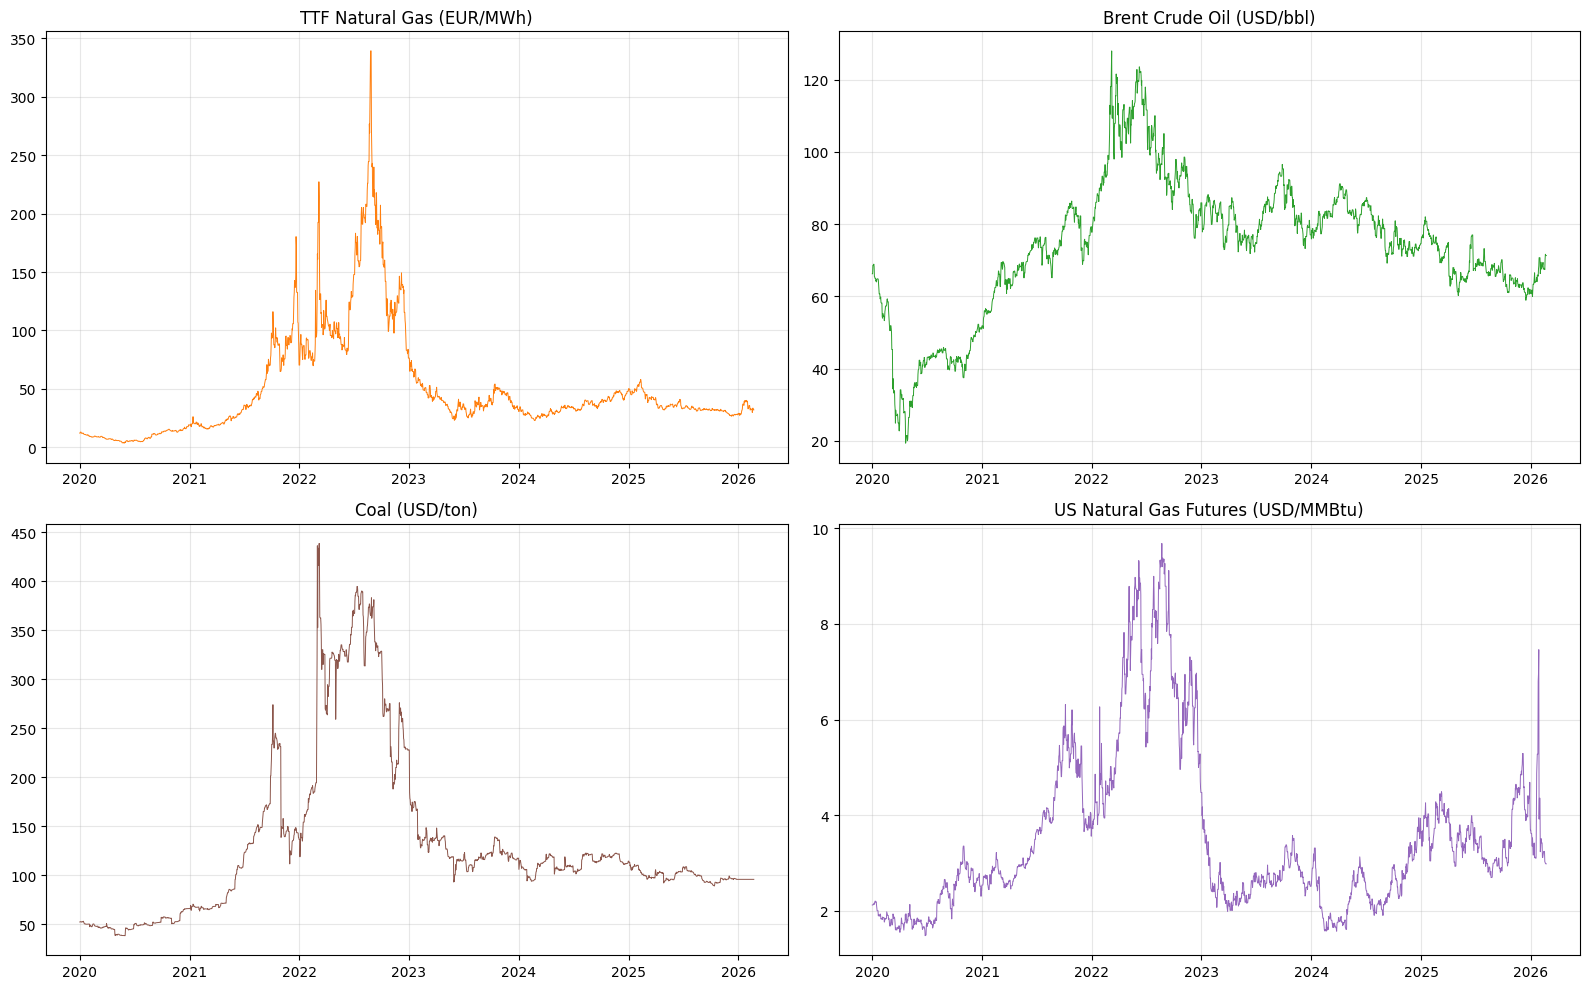

Notice the massive spike in 2022 — the energy crisis after Russia's invasion of Ukraine.
TTF gas went from ~20 EUR/MWh to ~340 EUR/MWh, dragging electricity prices with it.
Norwegian electricity prices followed, despite having abundant hydro.


In [3]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

commodities_plot = {
    "TTF-GAS_close": ("TTF Natural Gas (EUR/MWh)", "tab:orange", axes[0, 0]),
    "BRENTOIL-SPOT_close": ("Brent Crude Oil (USD/bbl)", "tab:green", axes[0, 1]),
    "COAL_close": ("Coal (USD/ton)", "tab:brown", axes[1, 0]),
    "NG-FUT_close": ("US Natural Gas Futures (USD/MMBtu)", "tab:purple", axes[1, 1]),
}

for col, (title, color, ax) in commodities_plot.items():
    if col in commodities.columns:
        ax.plot(commodities.index, commodities[col], color=color, linewidth=0.7)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice the massive spike in 2022 — the energy crisis after Russia's invasion of Ukraine.")
print("TTF gas went from ~20 EUR/MWh to ~340 EUR/MWh, dragging electricity prices with it.")
print("Norwegian electricity prices followed, despite having abundant hydro.")

## Feature: 7-day price change (trend signal)

Besides the absolute price, the **trend** matters. If gas prices have been rising for a week, electricity prices likely follow. We compute this as a percentage change over 7 days.

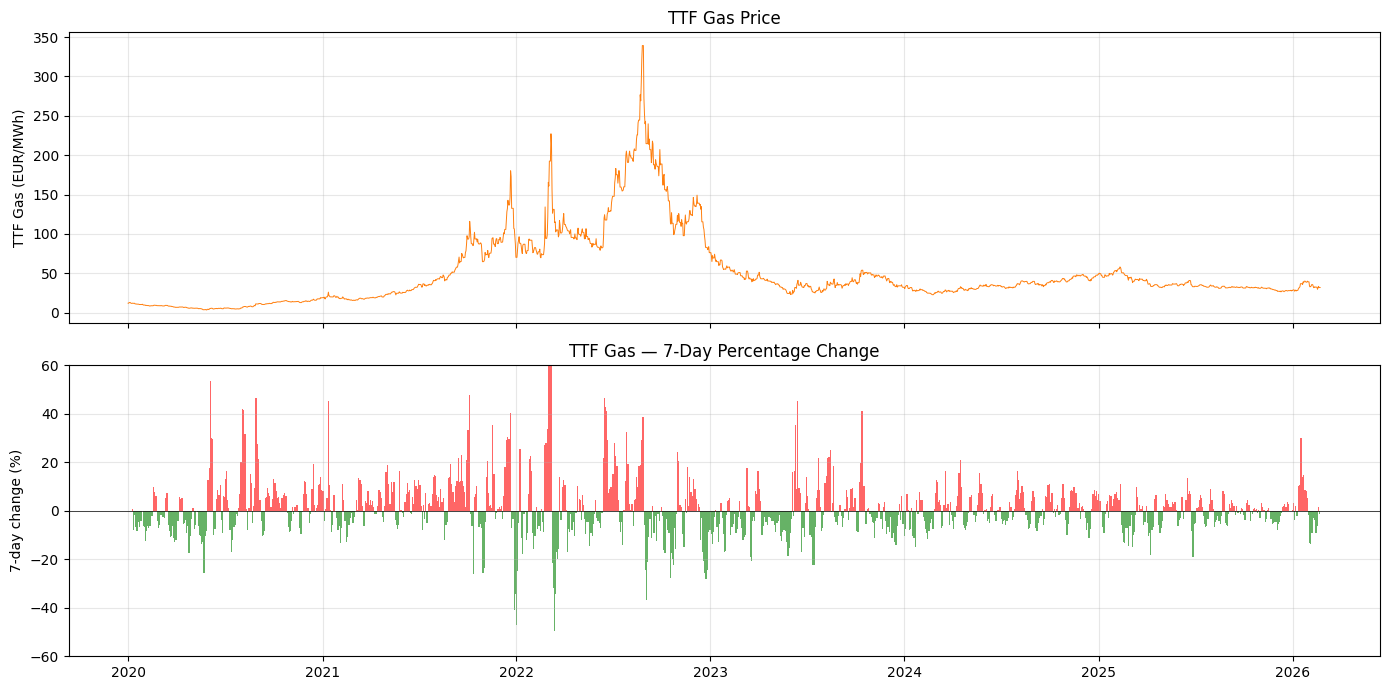

Average weekly change: 1.0%
Max weekly surge: 130.4%
Max weekly drop: -49.6%


In [4]:
if "TTF-GAS_close" in commodities.columns:
    ttf = commodities["TTF-GAS_close"]
    ttf_change_7d = ttf.pct_change(periods=7)

    fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

    ax = axes[0]
    ax.plot(ttf.index, ttf.values, color="tab:orange", linewidth=0.7)
    ax.set_ylabel("TTF Gas (EUR/MWh)")
    ax.set_title("TTF Gas Price")
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    ax.bar(ttf_change_7d.index, ttf_change_7d.values * 100, width=1,
           color=np.where(ttf_change_7d > 0, "red", "green"), alpha=0.6)
    ax.set_ylabel("7-day change (%)")
    ax.set_title("TTF Gas — 7-Day Percentage Change")
    ax.axhline(y=0, color="black", linewidth=0.5)
    ax.set_ylim(-60, 60)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Average weekly change: {ttf_change_7d.mean():.1%}")
    print(f"Max weekly surge: {ttf_change_7d.max():.1%}")
    print(f"Max weekly drop: {ttf_change_7d.min():.1%}")

## 2. EUR/NOK Exchange Rate

ENTSO-E reports prices in **EUR/MWh**, but Norwegian consumers pay in NOK. When EUR/NOK rises (NOK weakens), the same EUR price means more NOK for consumers.

This doesn't affect the EUR-denominated model directly, but it's useful for:
- Converting predictions to NOK for the dashboard
- Capturing cross-border arbitrage incentives (strong NOK → cheaper imports)

Shape: (2245, 1)
Range: 9.4923 to 12.3165


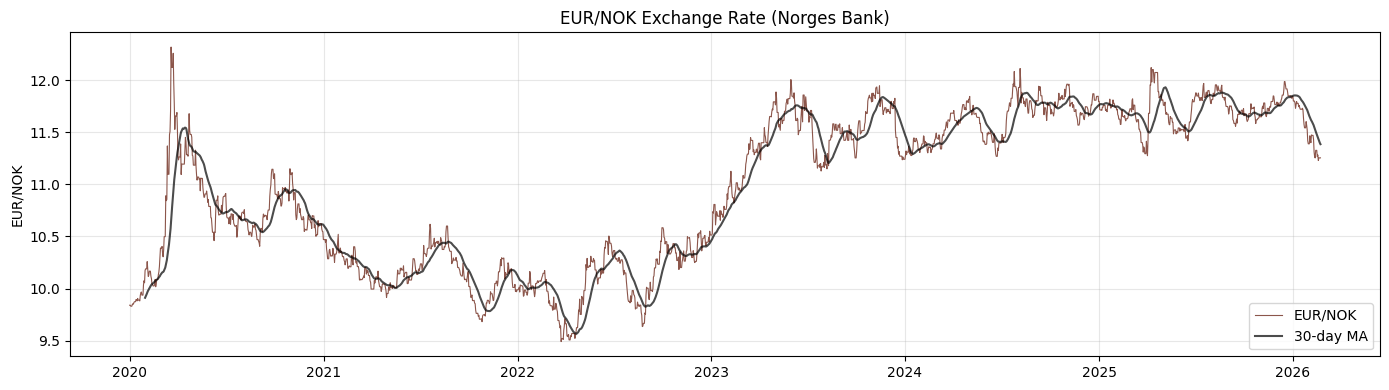


NOK has weakened over this period: 9.84 → 11.25
A weaker NOK means imports (and EUR-denominated electricity) cost more in NOK.


In [5]:
from src.data.fetch_fx import fetch_eur_nok_daily_filled

fx = fetch_eur_nok_daily_filled("2020-01-01", "2026-02-22", cache=True)

print(f"Shape: {fx.shape}")
print(f"Range: {fx['eur_nok'].min():.4f} to {fx['eur_nok'].max():.4f}")

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(fx.index, fx["eur_nok"], color="tab:brown", linewidth=0.8, label="EUR/NOK")
# 30-day moving average
ma30 = fx["eur_nok"].rolling(30).mean()
ax.plot(fx.index, ma30, color="black", linewidth=1.5, alpha=0.7, label="30-day MA")
ax.set_ylabel("EUR/NOK")
ax.set_title("EUR/NOK Exchange Rate (Norges Bank)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nNOK has weakened over this period: {fx['eur_nok'].iloc[0]:.2f} → {fx['eur_nok'].iloc[-1]:.2f}")
print("A weaker NOK means imports (and EUR-denominated electricity) cost more in NOK.")

## EUR → NOK Price Conversion

The FX rate lets us convert market prices (EUR/MWh) to Norwegian consumer units (NOK/kWh):

```
price_nok_mwh = price_eur_mwh × eur_nok
price_nok_kwh = price_nok_mwh / 1000
```

Norwegian households see prices in **NOK/kWh** (øre/kWh). The feature matrix now includes three price representations:
- `price_eur_mwh` — market standard (EUR/MWh)
- `price_nok_mwh` — Norwegian industry (NOK/MWh)  
- `price_nok_kwh` — consumer bills (NOK/kWh)

Each unit has its own lag/rolling/diff features, computed from the NOK series directly (not EUR lags × FX).

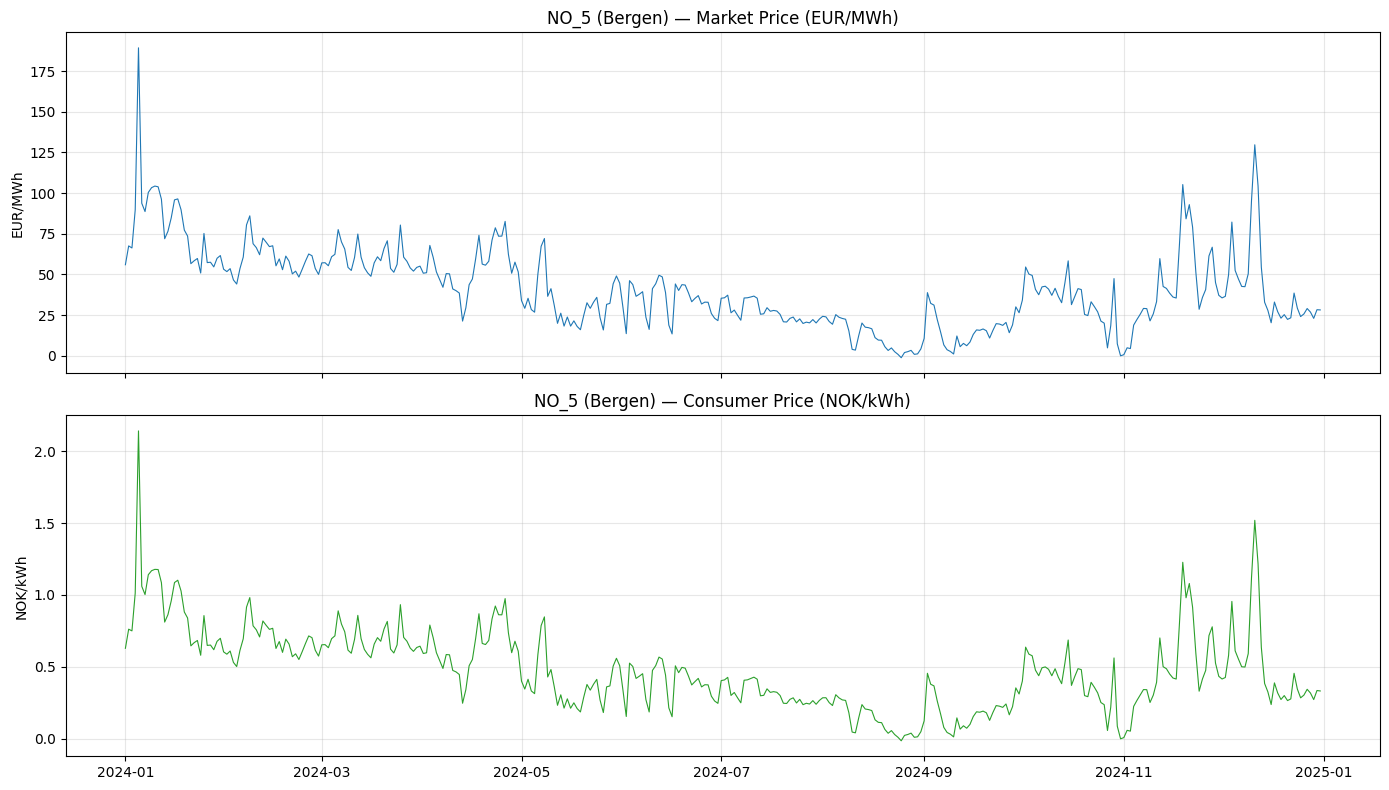

Average price (2024): 41.0 EUR/MWh = 0.475 NOK/kWh
A 2 kW heater at average price costs 0.95 NOK/hour


In [6]:
# Demonstrate EUR → NOK price conversion
from src.data.fetch_nordpool import fetch_prices

prices_no5 = fetch_prices("2024-01-01", "2024-12-31", cache=True)

if "NO_5" in prices_no5.columns:
    price_eur = prices_no5["NO_5"]

    # Strip tz for alignment with tz-naive FX data
    price_eur_naive = price_eur.copy()
    if price_eur_naive.index.tz is not None:
        price_eur_naive.index = price_eur_naive.index.tz_localize(None)

    # Convert EUR/MWh → NOK/MWh → NOK/kWh
    fx_aligned = fx["eur_nok"].reindex(price_eur_naive.index, method="ffill")
    price_nok_mwh = price_eur_naive * fx_aligned
    price_nok_kwh = price_nok_mwh / 1000

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Panel 1: EUR/MWh (market view)
    ax = axes[0]
    daily_eur = price_eur_naive.resample("D").mean()
    ax.plot(daily_eur.index, daily_eur.values, color="tab:blue", linewidth=0.8)
    ax.set_ylabel("EUR/MWh")
    ax.set_title("NO_5 (Bergen) — Market Price (EUR/MWh)")
    ax.grid(True, alpha=0.3)

    # Panel 2: NOK/kWh (consumer view)
    ax = axes[1]
    daily_nok = price_nok_kwh.resample("D").mean()
    ax.plot(daily_nok.index, daily_nok.values, color="tab:green", linewidth=0.8)
    ax.set_ylabel("NOK/kWh")
    ax.set_title("NO_5 (Bergen) — Consumer Price (NOK/kWh)")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Average price (2024): {daily_eur.mean():.1f} EUR/MWh = {daily_nok.mean():.3f} NOK/kWh")
    print(f"A 2 kW heater at average price costs {daily_nok.mean() * 2:.2f} NOK/hour")

## 3. Statnett: Norwegian Supply & Demand Balance

Statnett (Norway's grid operator) publishes daily production and consumption data. When Norway produces more than it consumes, it exports — which supports higher prices domestically.

In [7]:
from src.data.fetch_statnett import fetch_physical_flows, fetch_production_consumption

flows = fetch_physical_flows(cache=True)
prod_cons = fetch_production_consumption(cache=True)

print(f"Physical flows: {flows.shape}")
print(f"Production/consumption: {prod_cons.shape}")

Physical flows: (2245, 1)
Production/consumption: (2251, 3)


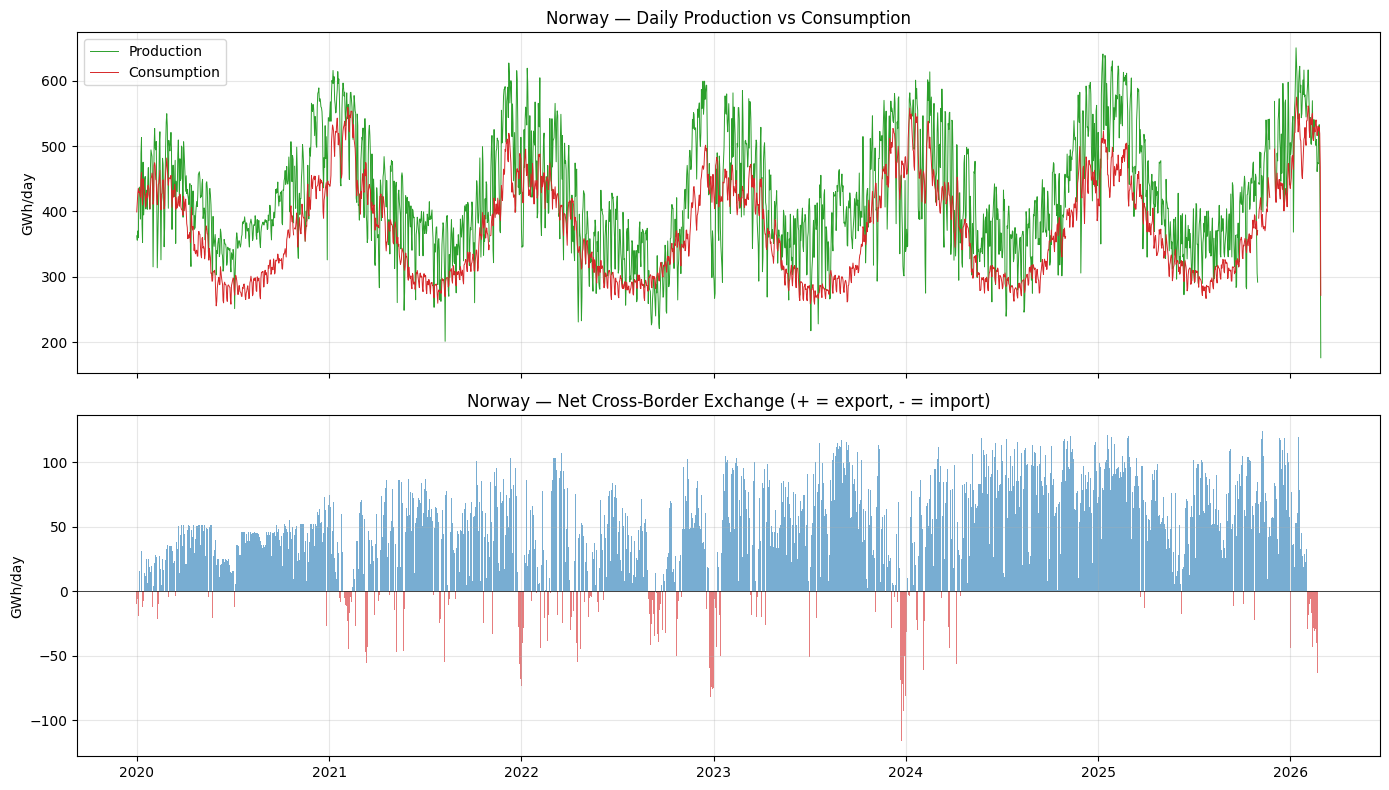

Norway is a net exporter 87.1% of the time.
Seasonal pattern: exports more in spring/summer (snow melt fills reservoirs).


In [8]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Panel 1: Production vs Consumption
ax = axes[0]
ax.plot(prod_cons.index, prod_cons["production_mwh"] / 1000,
        color="tab:green", linewidth=0.7, label="Production")
ax.plot(prod_cons.index, prod_cons["consumption_mwh"] / 1000,
        color="tab:red", linewidth=0.7, label="Consumption")
ax.set_ylabel("GWh/day")
ax.set_title("Norway — Daily Production vs Consumption")
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Net exchange
ax = axes[1]
colors = np.where(flows["net_exchange_mwh"] > 0, "tab:blue", "tab:red")
ax.bar(flows.index, flows["net_exchange_mwh"] / 1000, width=1,
       color=colors, alpha=0.6)
ax.axhline(y=0, color="black", linewidth=0.5)
ax.set_ylabel("GWh/day")
ax.set_title("Norway — Net Cross-Border Exchange (+ = export, - = import)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

export_pct = (flows["net_exchange_mwh"] > 0).mean()
print(f"Norway is a net exporter {export_pct:.1%} of the time.")
print("Seasonal pattern: exports more in spring/summer (snow melt fills reservoirs).")

## 4. NVE Reservoir Filling

This is arguably the **most important supply feature** for Norwegian electricity. Norway's grid is 95% hydro — reservoir levels directly determine how much cheap electricity is available.

- **High reservoir** (70%+): plenty of water → hydro producers can sell cheap → low prices
- **Low reservoir** (<40%): water scarcity → producers hold back → prices rise
- **Below historical minimum**: panic/scarcity premium → very high prices

In [9]:
from src.data.fetch_reservoir import fetch_zone_reservoir_with_benchmarks

reservoir = fetch_zone_reservoir_with_benchmarks("NO_5", "2020-01-01", "2026-02-22", cache=True)

print(f"Shape: {reservoir.shape}")
print(f"Columns: {list(reservoir.columns)}")
print(f"\nBasic stats:")
print(reservoir[["filling_pct", "filling_twh", "filling_change",
                 "filling_vs_median", "filling_vs_min"]].describe().round(3))

Shape: (320, 11)
Columns: ['zone', 'year', 'week', 'filling_pct', 'filling_twh', 'capacity_twh', 'filling_pct_prev_week', 'filling_change', 'filling_vs_median', 'filling_vs_min', 'filling_vs_max']

Basic stats:
       filling_pct  filling_twh  filling_change  filling_vs_median  \
count      320.000      320.000         320.000            320.000   
mean         0.581       10.105          -0.001             -0.013   
std          0.237        4.129           0.036              0.088   
min          0.094        1.641          -0.053             -0.294   
25%          0.389        6.770          -0.028             -0.068   
50%          0.611       10.617          -0.009              0.001   
75%          0.784       13.629           0.021              0.052   
max          0.951       16.543           0.150              0.153   

       filling_vs_min  
count         320.000  
mean            0.173  
std             0.100  
min             0.000  
25%             0.104  
50%           

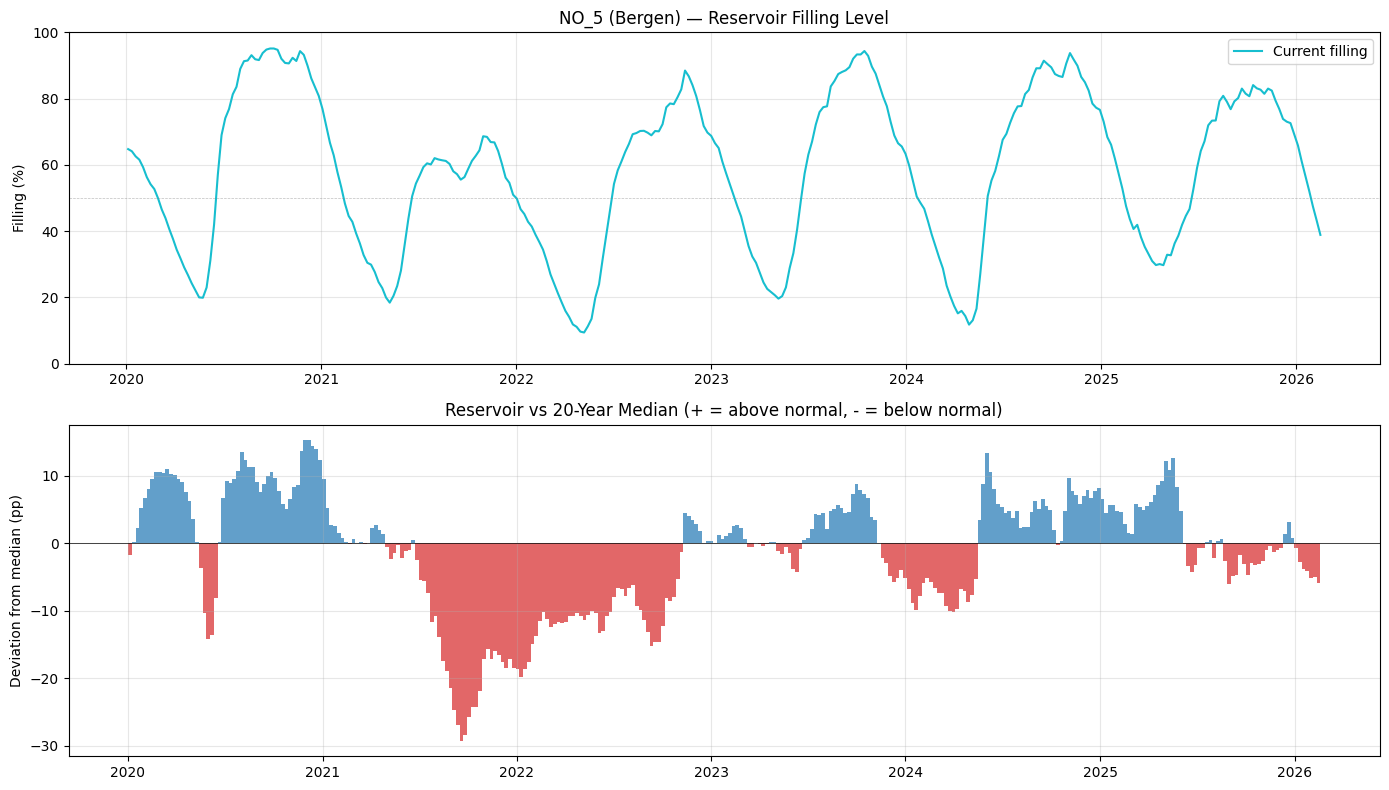

Notice the seasonal cycle: fill in spring/summer (snow melt), drain in winter.
Red bars (below median) signal potential scarcity → higher prices.


In [10]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Panel 1: Filling level with deviation from median
ax = axes[0]
ax.plot(reservoir.index, reservoir["filling_pct"] * 100,
        color="tab:cyan", linewidth=1.5, label="Current filling")
ax.axhline(y=50, color="gray", linewidth=0.5, linestyle="--", alpha=0.5)
ax.set_ylabel("Filling (%)")
ax.set_title("NO_5 (Bergen) — Reservoir Filling Level")
ax.set_ylim(0, 100)
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Deviation from historical median
ax = axes[1]
if "filling_vs_median" in reservoir.columns:
    vals = reservoir["filling_vs_median"].dropna() * 100
    colors = np.where(vals > 0, "tab:blue", "tab:red")
    ax.bar(vals.index, vals.values, width=7, color=colors, alpha=0.7)
    ax.axhline(y=0, color="black", linewidth=0.5)
    ax.set_ylabel("Deviation from median (pp)")
    ax.set_title("Reservoir vs 20-Year Median (+ = above normal, - = below normal)")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice the seasonal cycle: fill in spring/summer (snow melt), drain in winter.")
print("Red bars (below median) signal potential scarcity → higher prices.")

## Concept: Resampling Daily → Hourly (Forward-Fill)

Our target is hourly prices, but commodities, FX, and Statnett data are **daily**. Reservoir data is **weekly**. We need to align everything to the same hourly frequency.

The approach: **forward-fill** — assume the daily value holds for all 24 hours of that day.

```
Daily data:           Hourly (after forward-fill):
2024-01-15: 50€       2024-01-15 00:00: 50€
                      2024-01-15 01:00: 50€
                      ...
                      2024-01-15 23:00: 50€
2024-01-16: 52€       2024-01-16 00:00: 52€
                      ...
```

This is a reasonable assumption — gas prices don't change within a day (daily close), and reservoir data only updates weekly.

In [11]:
# Demonstrate forward-fill resampling
hourly_index = pd.date_range("2024-01-15", "2024-01-17", freq="h", tz="Europe/Oslo")

# Daily gas price (timezone-naive, like real data)
daily_gas = pd.DataFrame(
    {"ttf_gas": [50.0, 52.0, 48.0]},
    index=pd.to_datetime(["2024-01-15", "2024-01-16", "2024-01-17"]).tz_localize("Europe/Oslo"),
)

# Reindex to hourly with forward-fill
hourly_gas = daily_gas.reindex(hourly_index, method="ffill")

print("Daily data:")
print(daily_gas)
print(f"\nAfter forward-fill to hourly ({len(hourly_gas)} rows):")
# Show transition from Jan 15 to Jan 16
print(hourly_gas.loc["2024-01-15 22:00":"2024-01-16 02:00"])

print("\nThe value stays at 50€ until midnight, then jumps to 52€.")

Daily data:
                           ttf_gas
2024-01-15 00:00:00+01:00     50.0
2024-01-16 00:00:00+01:00     52.0
2024-01-17 00:00:00+01:00     48.0

After forward-fill to hourly (49 rows):
                           ttf_gas
2024-01-15 22:00:00+01:00     50.0
2024-01-15 23:00:00+01:00     50.0
2024-01-16 00:00:00+01:00     52.0
2024-01-16 01:00:00+01:00     52.0
2024-01-16 02:00:00+01:00     52.0

The value stays at 50€ until midnight, then jumps to 52€.


## Using our build_features module

All of the above is packaged in the individual `build_*` functions. Let's verify they work.

In [12]:
from src.features.build_features import (
    build_commodity_features,
    build_fx_features,
    build_statnett_features,
    build_reservoir_features,
)

start, end = "2020-01-01", "2026-02-22"

# Each returns a DataFrame at its native frequency (daily/weekly)
# The orchestrator (build_feature_matrix) resamples them to hourly
for name, func, args in [
    ("Commodities", build_commodity_features, (start, end)),
    ("FX", build_fx_features, (start, end)),
    ("Statnett", build_statnett_features, (start, end)),
    ("Reservoir", build_reservoir_features, ("NO_5", start, end)),
]:
    result = func(*args)
    print(f"{name:12s}: {result.shape[0]:>5,} rows x {result.shape[1]} cols | "
          f"Columns: {list(result.columns)}")

Commodities : 2,245 rows x 5 cols | Columns: ['ttf_gas_close', 'brent_oil_close', 'coal_close', 'ng_fut_close', 'ttf_gas_change_7d']
FX          : 2,245 rows x 1 cols | Columns: ['eur_nok']
Statnett    : 2,245 rows x 4 cols | Columns: ['net_exchange_mwh', 'production_mwh', 'consumption_mwh', 'net_balance_mwh']
Reservoir   :   320 rows x 5 cols | Columns: ['reservoir_filling_pct', 'reservoir_filling_twh', 'reservoir_filling_change', 'reservoir_vs_median', 'reservoir_vs_min']


## Key takeaways

1. **TTF Gas** is the #1 external price driver — gas sets the marginal price in Europe, which pulls Norway via cables
2. **Reservoir filling** is the #1 domestic supply factor — low reservoirs = scarcity = high prices
3. **Production vs Consumption** shows when Norway is a net exporter/importer
4. **EUR/NOK** affects the real cost for Norwegian consumers
5. **Forward-fill** is how we align daily/weekly data to hourly frequency
6. The 2022 energy crisis is clearly visible in every data source — a major regime change

**Next notebook:** 04_feature_matrix — merge everything together into the final training dataset